# Library

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from keras.preprocessing import text, sequence

from keras.models import Model, Sequential
from keras.layers import Flatten, Dense

from keras.layers import Dense, Embedding, Input, SimpleRNN, LSTM, Bidirectional
from keras.layers import Dropout, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPool1D

from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


# Data

## Train

In [2]:
df_train = pd.read_csv("../data/input/train.csv")
targets = [
    "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"
]

## Test

In [3]:
df_test = pd.read_csv("../data/input/test.csv")
df_test.loc[df_test.comment_text.isnull(), "comment_text"] = ""

# Train, Valid

In [4]:
any_category_positive = np.sum(df_train[targets], 1)

print('Distribution of Total Positive Labels (important for validation)')
print(pd.value_counts(any_category_positive))

X_train, X_val, y_train, y_val = train_test_split(
    df_train.comment_text,
    df_train[targets],
    test_size=0.3,
    stratify=any_category_positive,
    random_state=1607)
print('Training:', X_train.shape)
print('Testing:', X_val.shape)

Distribution of Total Positive Labels (important for validation)
0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
dtype: int64
Training: (111699,)
Testing: (47872,)


# Global parameters

In [5]:
batch_size = 32
epochs = 5
max_features = 20000
maxlen = 100

# Preprocessing : Tokens

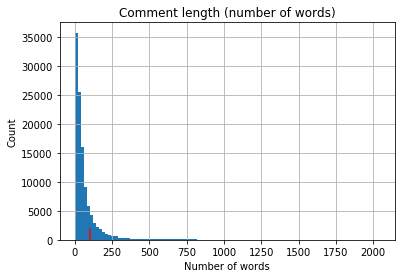

In [6]:
X_train.map(lambda x : len(x.split(" "))).hist(bins=100)
plt.vlines(100, ymin=0, ymax=2000, colors="red")
plt.title("Comment length (number of words)")
plt.xlabel("Number of words")
plt.ylabel("Count")
plt.show()

In [7]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))

list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_val = tokenizer.texts_to_sequences(X_val)

X_train = sequence.pad_sequences(list_tokenized_train, maxlen=maxlen)
X_val = sequence.pad_sequences(list_tokenized_val, maxlen=maxlen)

# Simple neural network

In [8]:
embedding_size = 50

In [9]:
# Define model
model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Flatten())
model.add(Dense(6, activation='sigmoid')) # 6 because we want to predict 6 classes

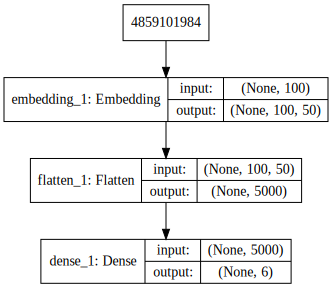

In [10]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [11]:
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
# Show model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 30006     
Total params: 1,030,006
Trainable params: 1,030,006
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Fit model
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

Train on 111699 samples, validate on 47872 samples
Epoch 1/5
111699/111699 [==============================] - 70s 623us/step - loss: 0.0791 - acc: 0.9752 - val_loss: 0.0708 - val_acc: 0.9784
Epoch 2/5
111699/111699 [==============================] - 88s 788us/step - loss: 0.0540 - acc: 0.9815 - val_loss: 0.0686 - val_acc: 0.9786
Epoch 3/5
111699/111699 [==============================] - 64s 571us/step - loss: 0.0401 - acc: 0.9859 - val_loss: 0.0692 - val_acc: 0.9793
Epoch 4/5
111699/111699 [==============================] - 82s 730us/step - loss: 0.0281 - acc: 0.9903 - val_loss: 0.0776 - val_acc: 0.9794
Epoch 5/5
111699/111699 [==============================] - 80s 713us/step - loss: 0.0200 - acc: 0.9937 - val_loss: 0.0860 - val_acc: 0.9792


In [14]:
model.save_weights('../data/work/simple_neural_network.h5')

In [15]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

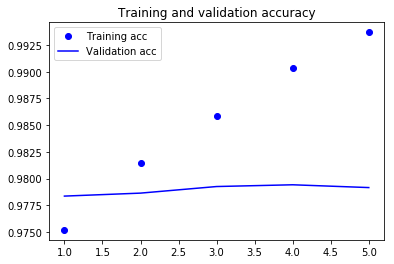

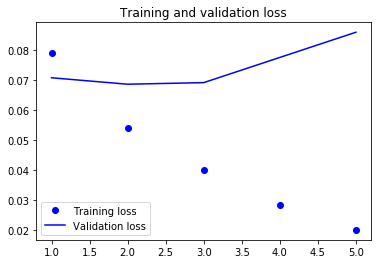

In [16]:
plot_history(history)

# Pre-trained embedding

In [17]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')


def get_embedding_matrix(tokenizer, path_glove, embed_size,
                         max_features=20000):
    embeddings_index = dict(
        get_coefs(*o.strip().split()) for o in open(path_glove))
    all_embs = np.stack(embeddings_index.values())
    emb_mean, emb_std = all_embs.mean(), all_embs.std()

    word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words,
                                                            embed_size))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [20]:
glove_path = "../data/glove/glove.6B.50d.txt"
embedding_matrix = get_embedding_matrix(
    tokenizer=tokenizer, path_glove=glove_path, embed_size=50, max_features=max_features)

# Simple neural network with pre-trained embedding

In [21]:
# Define model
model = Sequential()
model.add(
    Embedding(
        max_features,
        embedding_matrix.shape[1],
        input_length=maxlen,
        weights=[embedding_matrix]))
model.add(Flatten())
model.add(Dense(6, activation='sigmoid'))
# 6 because we want to predict 6 classes

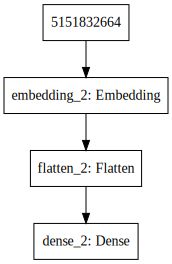

In [22]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [23]:
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
# Show model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 30006     
Total params: 1,030,006
Trainable params: 1,030,006
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Fit model
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

Train on 111699 samples, validate on 47872 samples
Epoch 1/5
111699/111699 [==============================] - 70s 629us/step - loss: 0.0850 - acc: 0.9734 - val_loss: 0.0706 - val_acc: 0.9778
Epoch 2/5
111699/111699 [==============================] - 57s 515us/step - loss: 0.0593 - acc: 0.9803 - val_loss: 0.0731 - val_acc: 0.9779
Epoch 3/5
111699/111699 [==============================] - 58s 515us/step - loss: 0.0459 - acc: 0.9843 - val_loss: 0.0747 - val_acc: 0.9783
Epoch 4/5
111699/111699 [==============================] - 57s 514us/step - loss: 0.0360 - acc: 0.9876 - val_loss: 0.0803 - val_acc: 0.9785
Epoch 5/5
111699/111699 [==============================] - 57s 514us/step - loss: 0.0283 - acc: 0.9904 - val_loss: 0.0853 - val_acc: 0.9776


In [26]:
model.save_weights('../data/work/simple_neural_network_pretrained_embedding.h5')

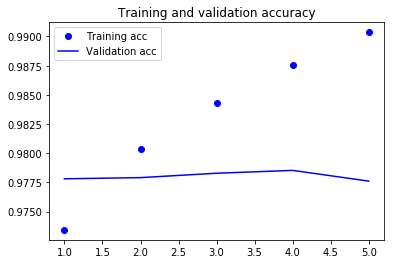

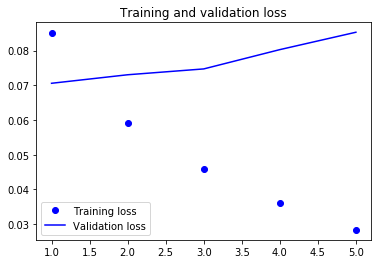

In [27]:
plot_history(history)

# Simple RNN

In [28]:
# Define model
model = Sequential()
model.add(Embedding(max_features, embedding_matrix.shape[1], weights=[embedding_matrix]))
model.add(SimpleRNN(32))
model.add(Dense(6, activation='sigmoid')) # 6 because we want to predict 6 classes

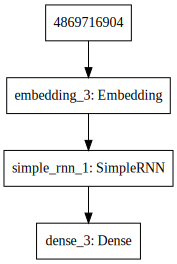

In [29]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [30]:
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
# Show model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 50)          1000000   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2656      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 198       
Total params: 1,002,854
Trainable params: 1,002,854
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Fit model
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

Train on 111699 samples, validate on 47872 samples
Epoch 1/5
111699/111699 [==============================] - 208s 2ms/step - loss: 0.0948 - acc: 0.9691 - val_loss: 0.0680 - val_acc: 0.9760
Epoch 2/5
111699/111699 [==============================] - 178s 2ms/step - loss: 0.0705 - acc: 0.9755 - val_loss: 0.0672 - val_acc: 0.9782
Epoch 3/5
111699/111699 [==============================] - 159s 1ms/step - loss: 0.0661 - acc: 0.9775 - val_loss: 0.0748 - val_acc: 0.9764
Epoch 4/5
111699/111699 [==============================] - 160s 1ms/step - loss: 0.0617 - acc: 0.9787 - val_loss: 0.0790 - val_acc: 0.9698
Epoch 5/5
111699/111699 [==============================] - 158s 1ms/step - loss: 0.0627 - acc: 0.9767 - val_loss: 0.0903 - val_acc: 0.9729


In [33]:
model.save_weights('../data/work/simple_rnn.h5')

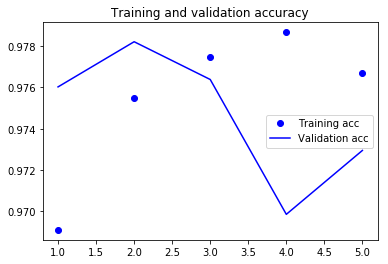

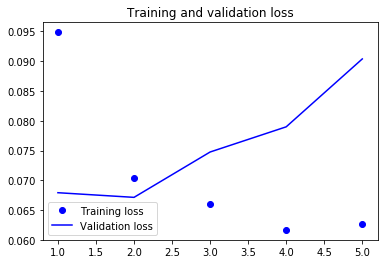

In [34]:
plot_history(history)

In [35]:
embedding_matrix.shape

(20000, 50)

# Stacked RNN

In [36]:
# Define model
model = Sequential()
model.add(
    Embedding(
        max_features, embedding_matrix.shape[1], weights=[embedding_matrix]))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.add(Dense(6, activation='sigmoid'))
# 6 because we want to predict 6 classes

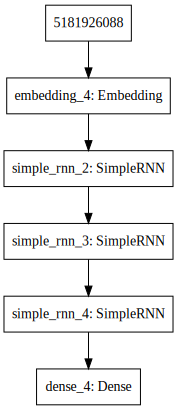

In [37]:
# Show model
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [38]:
# Compile model
model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
# Show model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 50)          1000000   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2656      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 198       
Total params: 1,007,014
Trainable params: 1,007,014
Non-trainable params: 0
_________________________________________________________________


In [40]:
# Fit model
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val))

Train on 111699 samples, validate on 47872 samples
Epoch 1/5
111699/111699 [==============================] - 339s 3ms/step - loss: 0.0853 - acc: 0.9722 - val_loss: 0.0672 - val_acc: 0.9766
Epoch 2/5
111699/111699 [==============================] - 338s 3ms/step - loss: 0.0702 - acc: 0.9764 - val_loss: 0.0708 - val_acc: 0.9753
Epoch 3/5
111699/111699 [==============================] - 337s 3ms/step - loss: 0.0626 - acc: 0.9781 - val_loss: 0.0659 - val_acc: 0.9765
Epoch 4/5
111699/111699 [==============================] - 339s 3ms/step - loss: 0.0739 - acc: 0.9761 - val_loss: 0.0710 - val_acc: 0.9778
Epoch 5/5
111699/111699 [==============================] - 338s 3ms/step - loss: 0.0664 - acc: 0.9781 - val_loss: 0.0675 - val_acc: 0.9780


In [41]:
model.save_weights('../data/work/stacked_rnn.h5')

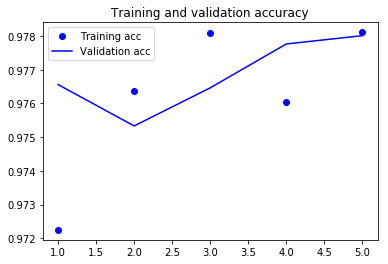

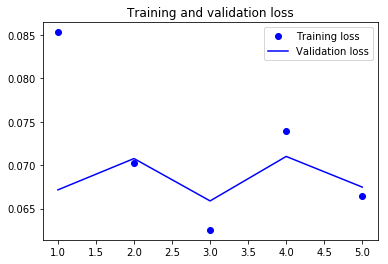

In [42]:
plot_history(history)

# LSTM

In [43]:
# Define model
model = Sequential()
model.add(
    Embedding(
        max_features, embedding_matrix.shape[1], weights=[embedding_matrix]))
model.add(LSTM(32))
model.add(Dense(6, activation='sigmoid'))
# 6 because we want to predict 6 classes

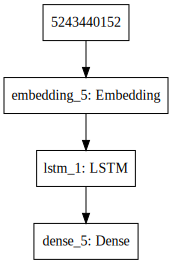

In [44]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [45]:
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [46]:
# Show model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 50)          1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                10624     
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 198       
Total params: 1,010,822
Trainable params: 1,010,822
Non-trainable params: 0
_________________________________________________________________


In [47]:
# Fit model
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

Train on 111699 samples, validate on 47872 samples
Epoch 1/5
111699/111699 [==============================] - 480s 4ms/step - loss: 0.0692 - acc: 0.9769 - val_loss: 0.0509 - val_acc: 0.9817
Epoch 2/5
111699/111699 [==============================] - 521s 5ms/step - loss: 0.0470 - acc: 0.9826 - val_loss: 0.0484 - val_acc: 0.9822
Epoch 3/5
111699/111699 [==============================] - 463s 4ms/step - loss: 0.0413 - acc: 0.9842 - val_loss: 0.0474 - val_acc: 0.9827
Epoch 4/5
111699/111699 [==============================] - 464s 4ms/step - loss: 0.0367 - acc: 0.9857 - val_loss: 0.0479 - val_acc: 0.9825
Epoch 5/5
111699/111699 [==============================] - 463s 4ms/step - loss: 0.0330 - acc: 0.9871 - val_loss: 0.0502 - val_acc: 0.9816


In [48]:
model.save_weights('../data/work/simple_lstm.h5')

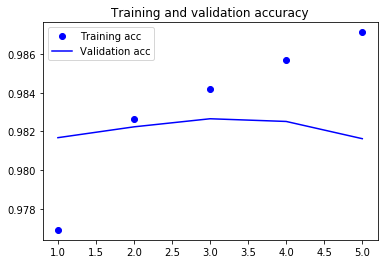

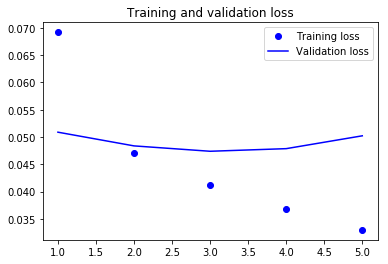

In [49]:
plot_history(history)

# Stacked LSTM

In [50]:
# Define model
model = Sequential()
model.add(
    Embedding(
        max_features, embedding_matrix.shape[1], weights=[embedding_matrix]))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(
    6, activation='sigmoid'))  
# 6 because we want to predict 6 classes

In [51]:
# Compile model
model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

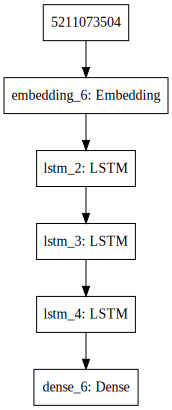

In [52]:
# Show model
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [53]:
# Show model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 50)          1000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 32)          10624     
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 198       
Total params: 1,027,462
Trainable params: 1,027,462
Non-trainable params: 0
_________________________________________________________________


In [54]:
# Fit model
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val))

Train on 111699 samples, validate on 47872 samples
Epoch 1/5
111699/111699 [==============================] - 1231s 11ms/step - loss: 0.0764 - acc: 0.9757 - val_loss: 0.0528 - val_acc: 0.9814
Epoch 2/5
111699/111699 [==============================] - 1201s 11ms/step - loss: 0.0481 - acc: 0.9823 - val_loss: 0.0501 - val_acc: 0.9820
Epoch 3/5
111699/111699 [==============================] - 1360s 12ms/step - loss: 0.0428 - acc: 0.9837 - val_loss: 0.0485 - val_acc: 0.9824
Epoch 4/5
111699/111699 [==============================] - 1406s 13ms/step - loss: 0.0387 - acc: 0.9849 - val_loss: 0.0507 - val_acc: 0.9822
Epoch 5/5
111699/111699 [==============================] - 1454s 13ms/step - loss: 0.0349 - acc: 0.9862 - val_loss: 0.0499 - val_acc: 0.9823


In [55]:
model.save_weights('../data/work/stacked_lstm.h5')

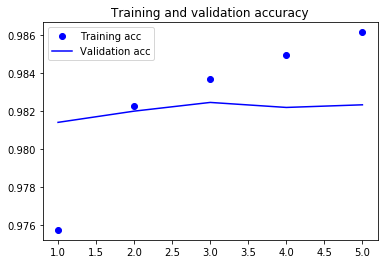

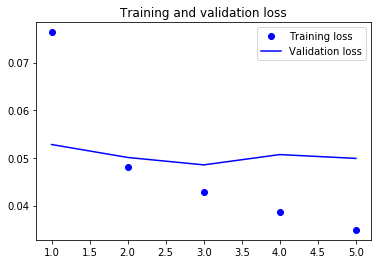

In [56]:
plot_history(history)

# Bi-LSTM

In [57]:
# Define model
model = Sequential()
model.add(Embedding(max_features, embedding_matrix.shape[1], weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(6, activation='sigmoid')) # 6 because we want to predict 6 classes

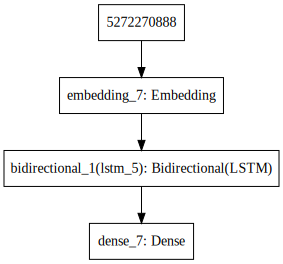

In [58]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [59]:
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
# Show model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 50)          1000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                21248     
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 390       
Total params: 1,021,638
Trainable params: 1,021,638
Non-trainable params: 0
_________________________________________________________________


In [61]:
# Fit model
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

Train on 111699 samples, validate on 47872 samples
Epoch 1/5
111699/111699 [==============================] - 624s 6ms/step - loss: 0.0665 - acc: 0.9773 - val_loss: 0.0503 - val_acc: 0.9819
Epoch 2/5
111699/111699 [==============================] - 579s 5ms/step - loss: 0.0462 - acc: 0.9826 - val_loss: 0.0476 - val_acc: 0.9825
Epoch 3/5
111699/111699 [==============================] - 523s 5ms/step - loss: 0.0404 - acc: 0.9843 - val_loss: 0.0470 - val_acc: 0.9826
Epoch 4/5
111699/111699 [==============================] - 602s 5ms/step - loss: 0.0362 - acc: 0.9858 - val_loss: 0.0474 - val_acc: 0.9825
Epoch 5/5
111699/111699 [==============================] - 558s 5ms/step - loss: 0.0323 - acc: 0.9871 - val_loss: 0.0494 - val_acc: 0.9823


In [62]:
model.save_weights('../data/work/bidirectional_lstm.h5')

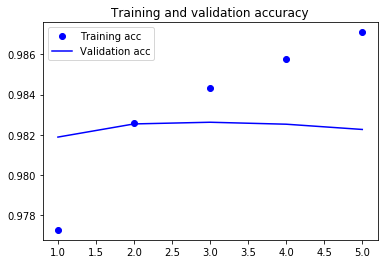

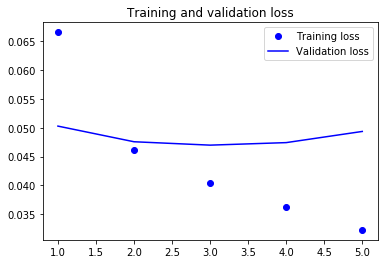

In [63]:
plot_history(history)

# Stacked Bi-LSTM

In [64]:
# Define model
model = Sequential()
model.add(Embedding(max_features, embedding_matrix.shape[1], weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(6, activation='sigmoid')) 
# 6 because we want to predict 6 classes

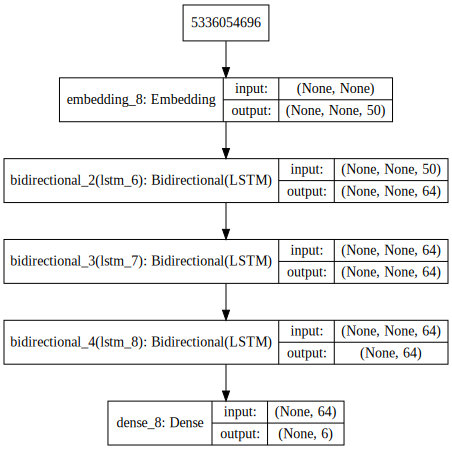

In [65]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [66]:
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [67]:
# Show model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 50)          1000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 64)          21248     
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 64)          24832     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 390       
Total params: 1,071,302
Trainable params: 1,071,302
Non-trainable params: 0
_________________________________________________________________


In [68]:
# Fit model
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

Train on 111699 samples, validate on 47872 samples
Epoch 1/5
111699/111699 [==============================] - 1645s 15ms/step - loss: 0.0662 - acc: 0.9773 - val_loss: 0.0509 - val_acc: 0.9816
Epoch 2/5
111699/111699 [==============================] - 1419s 13ms/step - loss: 0.0481 - acc: 0.9821 - val_loss: 0.0479 - val_acc: 0.9825
Epoch 3/5
111699/111699 [==============================] - 1363s 12ms/step - loss: 0.0434 - acc: 0.9834 - val_loss: 0.0487 - val_acc: 0.9820
Epoch 4/5
111699/111699 [==============================] - 1316s 12ms/step - loss: 0.0391 - acc: 0.9845 - val_loss: 0.0480 - val_acc: 0.9827
Epoch 5/5
111699/111699 [==============================] - 1450s 13ms/step - loss: 0.0355 - acc: 0.9858 - val_loss: 0.0490 - val_acc: 0.9824


In [69]:
model.save_weights('../data/work/stacked_bidirectional_lstm.h5')

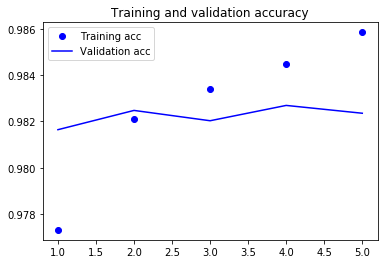

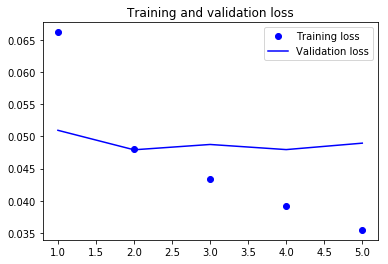

In [70]:
plot_history(history)

# LSTM, Pooling and regularization 

In [71]:
# Define model
model = Sequential()
model.add(
    Embedding(
        max_features, embedding_matrix.shape[1], weights=[embedding_matrix]))
model.add(
    Bidirectional(
        LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation="relu"))
model.add(Dense(6, activation='sigmoid'))

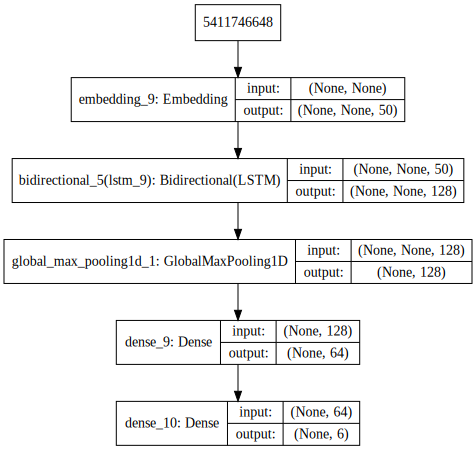

In [72]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [73]:
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [74]:
# Show model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 50)          1000000   
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 128)         58880     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 390       
Total params: 1,067,526
Trainable params: 1,067,526
Non-trainable params: 0
_________________________________________________________________


In [75]:
# Fit model
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

Train on 111699 samples, validate on 47872 samples
Epoch 1/5
111699/111699 [==============================] - 821s 7ms/step - loss: 0.0611 - acc: 0.9790 - val_loss: 0.0483 - val_acc: 0.9821
Epoch 2/5
111699/111699 [==============================] - 785s 7ms/step - loss: 0.0453 - acc: 0.9830 - val_loss: 0.0449 - val_acc: 0.9832
Epoch 3/5
111699/111699 [==============================] - 826s 7ms/step - loss: 0.0407 - acc: 0.9841 - val_loss: 0.0452 - val_acc: 0.9830
Epoch 4/5
111699/111699 [==============================] - 958s 9ms/step - loss: 0.0374 - acc: 0.9851 - val_loss: 0.0449 - val_acc: 0.9834
Epoch 5/5
111699/111699 [==============================] - 981s 9ms/step - loss: 0.0348 - acc: 0.9859 - val_loss: 0.0467 - val_acc: 0.9828


In [76]:
model.save_weights('../data/work/complete_lstm.h5')

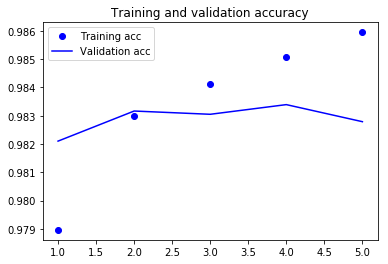

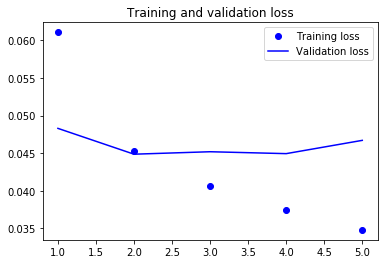

In [77]:
plot_history(history)